2025-11-19 17:06:57.314456: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763572017.340094    1696 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763572017.347558    1696 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

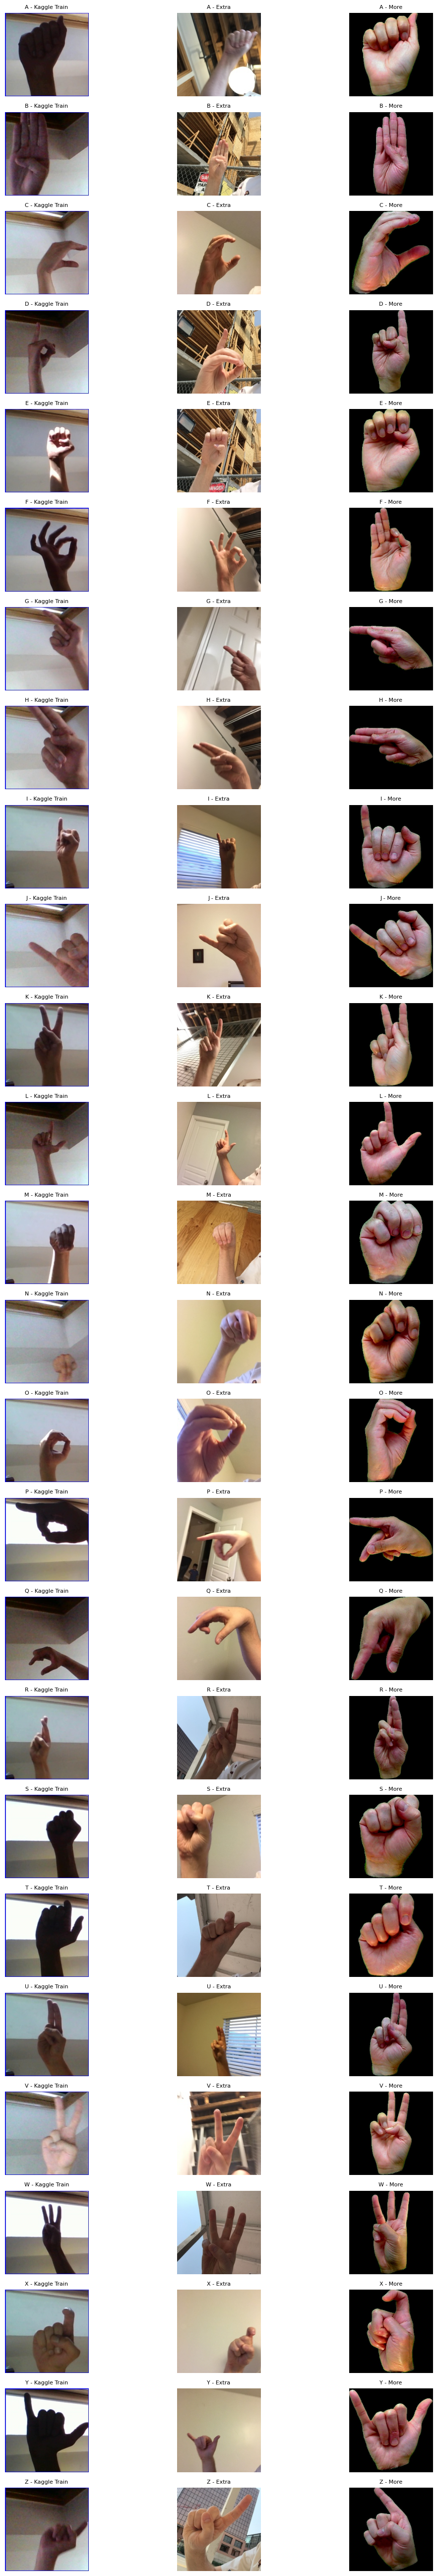

In [1]:
import os
import random
import matplotlib.pyplot as plt
import tensorflow as tf

# Define paths
TRAIN_DIR = '/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train'
EXTRA_TRAIN_DIR = '/kaggle/input/asl-alphabet-test'
MORE_TRAIN_DIR = '/kaggle/input/asl-dataset/asl_dataset'


# Image parameters
IMG_HEIGHT = 200
IMG_WIDTH = 200

# Ligeramente más pequeño para evitar OOM en Kaggle
BATCH_SIZE = 64           # <-- cambié de 64 a 32
VALIDATION_SPLIT = 0.2
SEED = 42

# Define the AUTOTUNE constant
AUTOTUNE = tf.data.AUTOTUNE

# Clases que quieres usar en TODO el pipeline
LETTER_CLASSES = [chr(i) for i in range(ord('A'), ord('Z')+1)]   # ['A', 'B', ..., 'Z']
LETTER_CLASSES_LOWER = [c.lower() for c in LETTER_CLASSES]       # ['a', 'b', ..., 'z']

num_classes = len(LETTER_CLASSES)  # 26

# Por si no lo tienes:
# LETTER_CLASSES = [chr(i) for i in range(ord('A'), ord('Z')+1)]

DATASETS = [
    ("Kaggle Train", TRAIN_DIR),
    ("Extra", EXTRA_TRAIN_DIR),
    ("More", MORE_TRAIN_DIR),
]

def find_class_dir(root_dir, letter):
    """
    Busca el folder de la letra dentro de root_dir.
    Solo acepta coincidencia exacta (ignorando mayúsculas/minúsculas).
    No va a mezclar 'S' con 'space'.
    """
    if not os.path.isdir(root_dir):
        return None
    
    dirs = [d for d in os.listdir(root_dir) 
            if os.path.isdir(os.path.join(root_dir, d))]
    
    # Coincidencia EXACTA de nombre para la letra
    for d in dirs:
        if d.lower() == letter.lower():
            return os.path.join(root_dir, d)
    
    # Si no hay coincidencia exacta, no la usamos
    return None



def get_one_image_path(root_dir, letter):
    """
    Devuelve la ruta de una imagen aleatoria para esa letra en ese dataset
    o None si no encuentra.
    """
    class_dir = find_class_dir(root_dir, letter)
    if class_dir is None:
        return None
    
    files = [f for f in os.listdir(class_dir) 
             if f.lower().endswith((".jpg", ".jpeg", ".png"))]
    
    if not files:
        return None
    
    img_name = random.choice(files)
    return os.path.join(class_dir, img_name)

# Visualizar una imagen por letra y por dataset
num_letters = len(LETTER_CLASSES)
num_datasets = len(DATASETS)

plt.figure(figsize=(4 * num_datasets, 2 * num_letters))

for row, letter in enumerate(LETTER_CLASSES):
    for col, (ds_name, ds_root) in enumerate(DATASETS):
        ax_index = row * num_datasets + col + 1
        ax = plt.subplot(num_letters, num_datasets, ax_index)
        
        img_path = get_one_image_path(ds_root, letter)
        
        if img_path is not None:
            img = tf.keras.utils.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
            plt.imshow(img)
            ax.set_title(f"{letter} - {ds_name}", fontsize=8)
        else:
            ax.text(0.5, 0.5, "Sin imagen", ha="center", va="center")
            ax.set_title(f"{letter} - {ds_name}", fontsize=8)
        
        ax.axis("off")

plt.tight_layout()
plt.show()


In [2]:
import os

# Define el path y las clases a excluir
MORE_TRAIN_DIR = '/kaggle/input/asl-dataset/asl_dataset'

# Lista completa de letras (D, F, M, N, T) y números (0-9) a excluir
items_to_exclude = ['D', 'F', 'M', 'N', 'T', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

# Obtener todas las carpetas/clases disponibles en el dataset
# Nota: Asumo que los nombres de las carpetas son el nombre de la clase (letra o número)
all_classes = os.listdir(MORE_TRAIN_DIR)

# 3. Filtrar las clases para obtener solo las deseadas
# Convertimos el nombre de la carpeta a mayúsculas para la comparación, 
# aunque es menos relevante para los números, funciona para ambos.
valid_classes = [
    class_name for class_name in all_classes 
    if class_name.upper() not in items_to_exclude
]

print("Clases excluidas:", items_to_exclude)
print(f"Número de clases Válidas restantes: {len(valid_classes)}")
print("Clases a incluir en MORE_TRAIN_DIR (muestro las primeras 10):")
print(valid_classes[:10])

Clases excluidas: ['D', 'F', 'M', 'N', 'T', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
Número de clases Válidas restantes: 22
Clases a incluir en MORE_TRAIN_DIR (muestro las primeras 10):
['r', 'b', 'i', 'h', 'e', 'u', 'x', 'asl_dataset', 'k', 'q']


In [4]:
import tensorflow as tf
from glob import glob

def create_dataset_from_filtered_dir(base_dir, valid_classes, img_height, img_width, batch_size):
    all_image_paths = []
    all_labels = []
    
    # Crea un mapeo de etiquetas (por ejemplo, {'A': 0, 'B': 1, ...})
    class_to_label = {name: i for i, name in enumerate(sorted(valid_classes))}
    
    print(f"Cargando archivos de {len(valid_classes)} clases...")

    for class_name in valid_classes:
        class_path = os.path.join(base_dir, class_name)
        
        # Busca todas las imágenes en esa carpeta
        image_paths = glob(os.path.join(class_path, '*.jpeg')) 
        image_paths.extend(glob(os.path.join(class_path, '*.jpg'))) # Incluir .jpg si es necesario
        
        # Asigna la etiqueta numérica a todas las imágenes encontradas
        label = class_to_label[class_name]
        
        all_image_paths.extend(image_paths)
        all_labels.extend([label] * len(image_paths))

    # Mezcla los datos
    temp = list(zip(all_image_paths, all_labels))
    random.shuffle(temp)
    all_image_paths, all_labels = zip(*temp)

    # 4. Crear un Dataset de tf.data a partir de las rutas filtradas
    
    # Función para cargar y preprocesar la imagen
    def load_and_preprocess_image(path, label):
        # Lee el archivo de imagen
        img = tf.io.read_file(path)
        # Decodifica como JPEG
        img = tf.image.decode_jpeg(img, channels=3)
        # Redimensiona la imagen
        img = tf.image.resize(img, [img_height, img_width])
        # Escala a [0, 1]
        img = img / 255.0
        return img, label

    # Crea el dataset de tensor slices con las rutas y etiquetas
    path_ds = tf.data.Dataset.from_tensor_slices((list(all_image_paths), list(all_labels)))
    
    # Mapea la función de carga al dataset
    image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

    # Aplica batch, shuffle y prefetching
    image_ds = image_ds.shuffle(buffer_size=1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    return image_ds, class_to_label

# Ejemplo de uso:
# Asegúrate de usar las variables que definiste en tu notebook:
# IMG_HEIGHT = 200, IMG_WIDTH = 200, BATCH_SIZE = ...
# MORE_DATASET, class_labels = create_dataset_from_filtered_dir(
#     MORE_TRAIN_DIR, valid_classes, IMG_HEIGHT, IMG_WIDTH, BATCH_SIZE
# )

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import matplotlib.pyplot as plt
import numpy as np


############################################
# 1) Dataset principal (con validation_split)
############################################
print("Loading main training/validation data (only letters A-Z)...")
train_main = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    validation_split=VALIDATION_SPLIT,
    subset="training",
    seed=SEED,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    class_names=LETTER_CLASSES,
)

validation_main = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    validation_split=VALIDATION_SPLIT,
    subset="validation",
    seed=SEED,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    class_names=LETTER_CLASSES,
)

class_names = train_main.class_names
print("Clases detectadas en TRAIN_DIR:", class_names)

############################################
# 2) Helper para crear train/val de otros dirs
############################################
def make_train_val_from_dir(
    data_dir,
    img_size,
    batch_size,
    val_split,
    seed,
    class_names
):
    """
    Carga un dataset desde 'data_dir', lo baraja y lo parte en train/val
    usando take/skip a nivel de BATCHES.
    """
    print(f"\nLoading data from: {data_dir}")
    ds = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        seed=seed,
        image_size=img_size,
        batch_size=batch_size,
        shuffle=True,
        label_mode='categorical',
        class_names=class_names,
    )

    num_batches = tf.data.experimental.cardinality(ds).numpy()
    val_batches = max(1, int(num_batches * val_split))

    print(f"  Total batches: {num_batches}, val_batches: {val_batches}")

    val_ds = ds.take(val_batches)
    train_ds = ds.skip(val_batches)

    return train_ds, val_ds

############################################
# 3) Extra datasets (train/val separados)
############################################
# EXTRA_TRAIN_DIR usa nombres de carpetas tipo 'A', 'B', ...
train_extra, val_extra = make_train_val_from_dir(
    EXTRA_TRAIN_DIR,
    img_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    val_split=VALIDATION_SPLIT,
    seed=SEED,
    class_names=LETTER_CLASSES,
)

# MORE_TRAIN_DIR usa nombres de carpetas tipo 'a', 'b', ...
train_more, val_more = make_train_val_from_dir(
    MORE_TRAIN_DIR,
    img_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    val_split=VALIDATION_SPLIT,
    seed=SEED,
    class_names=LETTER_CLASSES_LOWER,
)

############################################
# 4) Combinar TODO en un solo train y un solo val
############################################
print("\nCombining all train datasets...")
train_generator = (
    train_main
    .concatenate(train_extra)
    #.concatenate(train_more)
)

print("Combining all validation datasets...")
validation_generator = (
    validation_main
    .concatenate(val_extra)
    #.concatenate(val_more)
)

############################################
# 5) Data augmentation & prefetch
############################################
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal", seed=SEED),
        layers.RandomRotation(0.1, seed=SEED),
        layers.RandomZoom(0.2, seed=SEED),
        layers.RandomBrightness(0.2, seed=SEED), 
        layers.RandomContrast(0.2, seed=SEED),
        layers.RandomTranslation(height_factor=0.2, width_factor=0.2, seed=SEED),
    ],
    name="data_augmentation"
)

# Prefetch para que el GPU no espere
train_generator = train_generator.prefetch(buffer_size=AUTOTUNE)
validation_generator = validation_generator.prefetch(buffer_size=AUTOTUNE)

print("\nFinal combined train/validation datasets are ready and prefetched.")


In [1]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# --- RUTAS ---
DS1_DIR = '/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train'
DS2_DIR = '/kaggle/input/asl-alphabet-test' 
DS3_DIR = '/kaggle/input/asl-dataset/asl_dataset'

file_paths = []
labels = []

# Definimos las letras que queremos excluir ESPECÍFICAMENTE del Dataset 3
ds3_excluded_letters = ['D', 'F', 'T']

def process_dataset(directory, dataset_type):
    if not os.path.exists(directory):
        print(f"No encontrado: {directory}")
        return

    print(f"Procesando Dataset {dataset_type}: {directory}...")
    
    # Listar elementos en el directorio
    items = os.listdir(directory)
    
    for item_name in items:
        item_path = os.path.join(directory, item_name)
        
        # 1. Si no es carpeta, lo ignoramos (esto evita leer imágenes sueltas en la raíz como clases)
        if not os.path.isdir(item_path):
            continue
            
        # --- FILTRO MAESTRO ---
        # Si el nombre de la carpeta tiene más de 1 letra, NO ES UNA LETRA (A-Z).
        # Esto elimina automáticamente: 'del', 'space', 'nothing', 'ASL_DATASET', 'ASL-ALPHABET-TEST'
        if len(item_name) > 1:
            continue
            
        # Normalizar a mayúscula
        label = item_name.upper()
        
        # --- REGLAS ESPECÍFICAS POR DATASET ---
        
        # Dataset 3: Excluir números y las letras D, F, T
        if dataset_type == 3:
            if item_name.isdigit(): # Ignorar carpetas '0', '1', etc.
                continue
            if label in ds3_excluded_letters: # Ignorar D, F, T
                continue
        
        # Verificar que sea una letra válida (A-Z) para mayor seguridad
        if not label.isalpha():
            continue

        # --- RECOLECCIÓN DE IMÁGENES ---
        # Entramos a la carpeta de la clase (ej: /A)
        for img_name in os.listdir(item_path):
            img_path = os.path.join(item_path, img_name)
            
            # IMPORTANTE: Verificar que sea un archivo (jpg/png) y no una subcarpeta
            if os.path.isfile(img_path):
                file_paths.append(img_path)
                labels.append(label)

# Ejecutar proceso
process_dataset(DS1_DIR, dataset_type=1)
process_dataset(DS2_DIR, dataset_type=2)
process_dataset(DS3_DIR, dataset_type=3)

# Crear DataFrame
df = pd.DataFrame({'filepath': file_paths, 'label': labels})

# Verificar limpieza
print(f"Total de imágenes: {len(df)}")
unique_labels = sorted(df['label'].unique())
print(f"Clases encontradas ({len(unique_labels)}): {unique_labels}")

# Check de seguridad: Debería imprimir solo letras de la A a la Z
if len(unique_labels) > 26:
    print("⚠️ ADVERTENCIA: Aún hay clases extrañas, revisa la lista de arriba.")

# --- GENERADORES ---
# Mezclar y dividir
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

BATCH_SIZE = 32
IMG_HEIGHT = 200
IMG_WIDTH = 200

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

print("Creando generador de Train...")
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col='label',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

print("Creando generador de Val...")
validation_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filepath',
    y_col='label',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

2025-11-19 17:22:31.389936: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763572951.623847      48 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763572951.690507      48 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

Procesando Dataset 1: /kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train...
Procesando Dataset 2: /kaggle/input/asl-alphabet-test...
Procesando Dataset 3: /kaggle/input/asl-dataset/asl_dataset...
Total de imágenes: 80390
Clases encontradas (26): ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
Creando generador de Train...
Found 64312 validated image filenames belonging to 26 classes.
Creando generador de Val...
Found 16078 validated image filenames belonging to 26 classes.


In [2]:
num_classes = len(train_generator.class_indices)
print(f"Entrenando para {num_classes} clases.")

Entrenando para 26 clases.


In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# --- 1. Configuración Automática ---
# Obtenemos el número de clases directamente del generador (debería ser 26)
num_classes = len(train_generator.class_indices)
print(f"Configurando modelo para {num_classes} clases...")

# --- 2. Definir el Modelo (Basado en tu notebook original) ---
def create_asl_cnn_model(input_shape, num_classes):
    model = models.Sequential([
        # Capa de entrada
        layers.Input(shape=input_shape),
        
        # Bloque Convolucional 1
        layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.BatchNormalization(),
        
        # Bloque Convolucional 2
        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.BatchNormalization(),
        
        # Bloque Convolucional 3
        layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.BatchNormalization(),
        
        # Bloque Convolucional 4 (Añadido para mayor capacidad dado que son 3 datasets)
        layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.BatchNormalization(),
        
        # Aplanado y Denso
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5), # Reduce sobreajuste
        
        # Capa de Salida
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Crear el modelo
model = create_asl_cnn_model(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), # 200, 200, 3
    num_classes=num_classes
)

# --- 3. Compilar ---
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# --- 4. Callbacks (Importante para no perder tiempo) ---
callbacks = [
    EarlyStopping(
        monitor='val_accuracy', 
        patience=5,          # Si no mejora en 5 épocas, para
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_accuracy', 
        factor=0.5,          # Reduce aprendizaje a la mitad si se estanca
        patience=3,
        min_lr=1e-6,
        verbose=1
    ),
    ModelCheckpoint(
        'best_asl_model_combined.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

# --- 5. Entrenar ---
print("\nIniciando entrenamiento...")
history = model.fit(
    train_generator,
    epochs=30, # Pongo 30, pero EarlyStopping parará antes si es necesario
    validation_data=validation_generator,
    callbacks=callbacks
)

Configurando modelo para 26 clases...


I0000 00:00:1763573400.900733      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 200, 200, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 100, 100, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 100, 100, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 100, 100, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 50, 50, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 50, 50, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 25, 25, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 25, 25, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,874,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 26)             │        13,338 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,280,602 (73.55 MB)

 Trainable params: 19,278,618 (73.54 MB)

 Non-trainable params: 1,984 (7.75 KB)


Iniciando entrenamiento...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


I0000 00:00:1763573407.450086     107 service.cc:148] XLA service 0x7a0e8c018a80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763573407.451050     107 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1763573408.067160     107 cuda_dnn.cc:529] Loaded cuDNN version 90300


   1/2010 ━━━━━━━━━━━━━━━━━━━━ 5:48:34 10s/step - accuracy: 0.0312 - loss: 4.7197

I0000 00:00:1763573413.881420     107 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2010/2010 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - accuracy: 0.4620 - loss: 2.0270
Epoch 1: val_accuracy improved from -inf to 0.85508, saving model to best_asl_model_combined.keras
2010/2010 ━━━━━━━━━━━━━━━━━━━━ 974s 480ms/step - accuracy: 0.4621 - loss: 2.0266 - val_accuracy: 0.8551 - val_loss: 0.4520 - learning_rate: 0.0010
Epoch 2/30
2010/2010 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - accuracy: 0.9096 - loss: 0.2715
Epoch 2: val_accuracy did not improve from 0.85508
2010/2010 ━━━━━━━━━━━━━━━━━━━━ 586s 291ms/step - accuracy: 0.9096 - loss: 0.2715 - val_accuracy: 0.7828 - val_loss: 0.8856 - learning_rate: 0.0010
Epoch 3/30
2010/2010 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - accuracy: 0.9536 - loss: 0.1475
Epoch 3: val_accuracy did not improve from 0.85508
2010/2010 ━━━━━━━━━━━━━━━━━━━━ 586s 291ms/step - accuracy: 0.9536 - loss: 0.1475 - val_accuracy: 0.7932 - val_loss: 1.0135 - learning_rate: 0.0010
Epoch 4/30
2010/2010 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - accuracy: 0.9680 - loss: 0.1023
Epoch 4: 